In [1]:
!git clone https://github.com/calvin050101/6006CEM-Project.git

Cloning into '6006CEM-Project'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 73 (delta 18), reused 63 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 14.09 MiB | 15.73 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [2]:
import matplotlib.pyplot as plt
import joblib

X_train, X_test, y_train, y_test = joblib.load('/content/6006CEM-Project/Adult Census Income/artifacts/final_census_data.pkl')

In [3]:
y_probas = {}
ap_scores = {}  # store average precision

# Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [6]:
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
)

y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred, average='weighted'),
    "ROC AUC": roc_auc_score(y_test, y_pred_proba).item()
}

metrics

{'Accuracy': 0.8105403602401601,
 'Precision': 0.5804901489668428,
 'Recall': 0.8212100611828688,
 'F1': 0.8199621268084761,
 'ROC AUC': 0.8949537090940504}

In [7]:
from sklearn.metrics import average_precision_score
model_name = "Random Forest"

y_scores = rf_model.predict_proba(X_test)[:, 1]

y_probas[model_name] = y_scores
ap_scores[model_name] = average_precision_score(y_test, y_scores)

# Feed Forward Neural Network

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

nn_model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid')  # For binary classification
])

nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

In [9]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        reduce_lr
    ]
)

Epoch 1/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7640 - auc: 0.8388 - loss: 0.5092 - val_accuracy: 0.7799 - val_auc: 0.8847 - val_loss: 0.4328 - learning_rate: 0.0010
Epoch 2/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7977 - auc: 0.8790 - loss: 0.4324 - val_accuracy: 0.7780 - val_auc: 0.8921 - val_loss: 0.4133 - learning_rate: 0.0010
Epoch 3/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7984 - auc: 0.8829 - loss: 0.4248 - val_accuracy: 0.7880 - val_auc: 0.8936 - val_loss: 0.4099 - learning_rate: 0.0010
Epoch 4/50
561/566 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8037 - auc: 0.8857 - loss: 0.4201
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
566/566 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8037 - auc: 0.8857 - loss: 0.4201 - val_accuracy: 0.7879 - val_auc: 0.8945 - val_loss: 0.4186 - learning_rate: 0.0010
Epoch 5/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8031 - auc: 0.8855 - loss: 0.4198

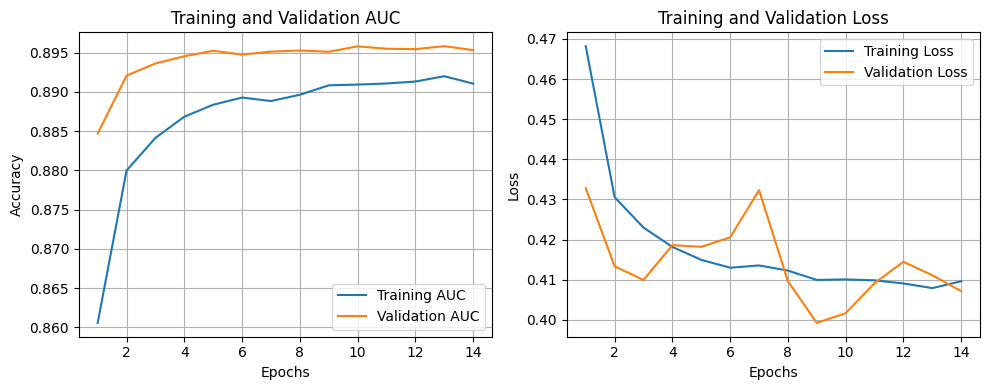

In [10]:
import matplotlib.pyplot as plt

# Get training history
acc = history.history.get('auc')
val_acc = history.history.get('val_auc')
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training AUC')
plt.plot(epochs, val_acc, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
y_pred_proba = nn_model.predict(X_test)
if y_pred_proba.shape[-1] == 1:
      y_pred_proba = y_pred_proba.flatten()
y_pred = (y_pred_proba > 0.5).astype("int32")

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred, average='weighted'),
    "ROC AUC": roc_auc_score(y_test, y_pred_proba).item()
}

metrics

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


{'Accuracy': 0.7966977985323549,
 'Precision': 0.5565022421524664,
 'Recall': 0.8436437797416724,
 'F1': 0.8082387216255863,
 'ROC AUC': 0.8951398492400029}

In [12]:
model_name = "Feed Forward"
y_probas[model_name] = y_pred_proba
ap_scores[model_name] = average_precision_score(y_test, y_pred_proba)

Use F1-score

Why: Balances precision and recall, so it doesn’t favor the majority class.

When: After SMOTE-NC, classes are balanced in training, but test set should stay imbalanced — so the F1 gives a fairer view.

# Base Classification Evaluation

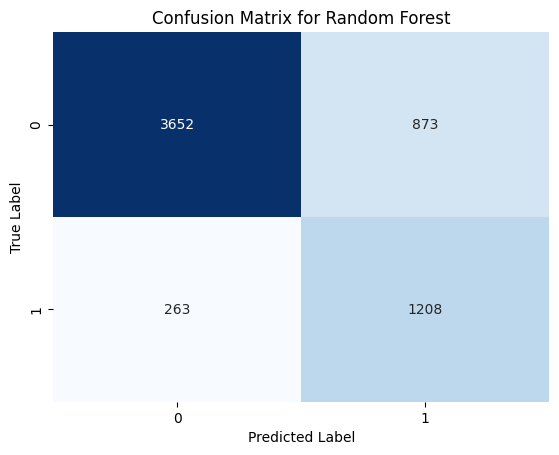

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = rf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [14]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      4525
           1       0.58      0.82      0.68      1471

    accuracy                           0.81      5996
   macro avg       0.76      0.81      0.77      5996
weighted avg       0.85      0.81      0.82      5996



188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


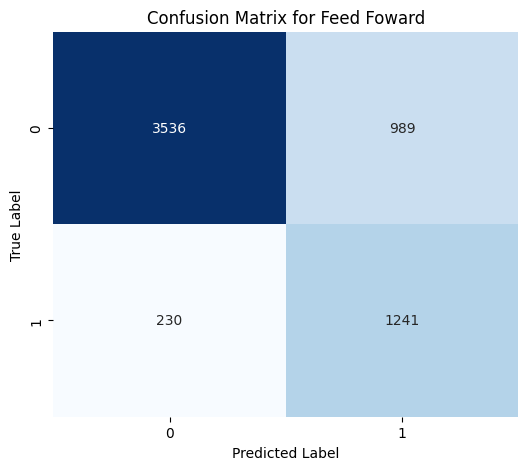

In [15]:
# Get predicted probabilities
y_pred_prob = nn_model.predict(X_test)

# Convert probabilities to binary labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Feed Foward')
plt.show()

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.78      0.85      4525
           1       0.56      0.84      0.67      1471

    accuracy                           0.80      5996
   macro avg       0.75      0.81      0.76      5996
weighted avg       0.85      0.80      0.81      5996



# Hyperparameter Tuning

## Random Forest

In [17]:
# Grid Search Hyperparameter Tuning (Random Forest)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Stratified 3-fold cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_grid = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_grid.fit(X_train, y_train)
best_rf_model = rf_grid.best_estimator_
print("Best Hyperparameters:", rf_grid.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}


In [18]:
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred, average='weighted'),
    "ROC AUC": roc_auc_score(y_test, y_pred_proba).item()
}

metrics

{'Accuracy': 0.80920613742495,
 'Precision': 0.5773781353525793,
 'Recall': 0.8293677770224337,
 'F1': 0.8190104246953681,
 'ROC AUC': 0.8983411142117775}

In [19]:
model_name = "Tuned Random Forest"
y_scores = best_rf_model.predict_proba(X_test)[:, 1]

y_probas[model_name] = y_scores
ap_scores[model_name] = average_precision_score(y_test, y_scores)

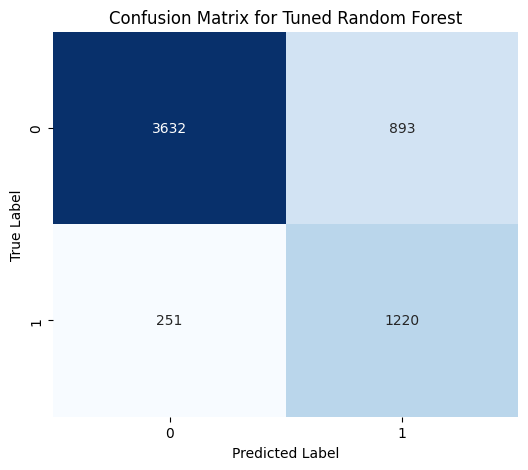

In [27]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Tuned Random Forest')
plt.show()

In [20]:
y_pred = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86      4525
           1       0.58      0.83      0.68      1471

    accuracy                           0.81      5996
   macro avg       0.76      0.82      0.77      5996
weighted avg       0.85      0.81      0.82      5996



## Feed Forward Neural Network

In [21]:
%pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.4 MB/s eta 0:00:00


In [22]:
from keras import layers, models, regularizers

def build_model(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Choice(f'units_{i}', [64, 128, 256]),
            activation=hp.Choice('activation', ['relu', 'leaky_relu', 'elu']),
            kernel_regularizer=regularizers.l2(hp.Choice('l2', [1e-4, 1e-3, 1e-2]))
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    return model

In [23]:
from keras_tuner import Objective, RandomSearch
import shutil

# Optional: remove old results folder
shutil.rmtree('/content/tuner_results/binary_nn_tuning', ignore_errors=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    seed=42,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='binary_nn_tuning'
)

tuner.search(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, reduce_lr]
  )

Trial 30 Complete [00h 00m 58s]
val_accuracy: 0.8008672595024109

Best val_accuracy So Far: 0.8168779015541077
Total elapsed time: 00h 30m 55s


In [26]:
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [24]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.get('num_layers'))

3


In [25]:
print(best_hps.get('units_0'))
print(best_hps.get('units_1'))
print(best_hps.get('units_2'))
print(best_hps.get('activation'))
print(best_hps.get('l2'))
print(best_hps.get('dropout'))
print(best_hps.get('optimizer'))

128
64
128
relu
0.01
0.30000000000000004
adamw


In [28]:
# Get predicted probabilities
y_pred_proba = best_model.predict(X_test)

# Convert probabilities to binary labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype("int32")

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred, average='weighted'),
    "ROC AUC": roc_auc_score(y_test, y_pred_proba).item()
}

metrics

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


{'Accuracy': 0.7966977985323549,
 'Precision': 0.5565022421524664,
 'Recall': 0.8436437797416724,
 'F1': 0.8082387216255863,
 'ROC AUC': 0.8894193824624133}

In [29]:
model_name = "Tuned Feed Forward"

y_probas[model_name] = y_pred_proba
ap_scores[model_name] = average_precision_score(y_test, y_pred_proba)

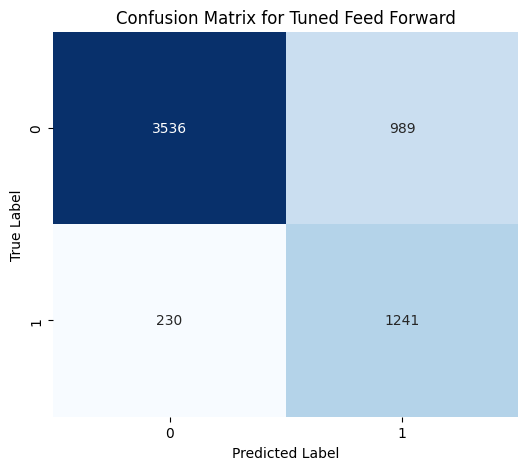

In [30]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Tuned Feed Forward')
plt.show()

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.78      0.85      4525
           1       0.56      0.84      0.67      1471

    accuracy                           0.80      5996
   macro avg       0.75      0.81      0.76      5996
weighted avg       0.85      0.80      0.81      5996



# Final Classification Evaluation

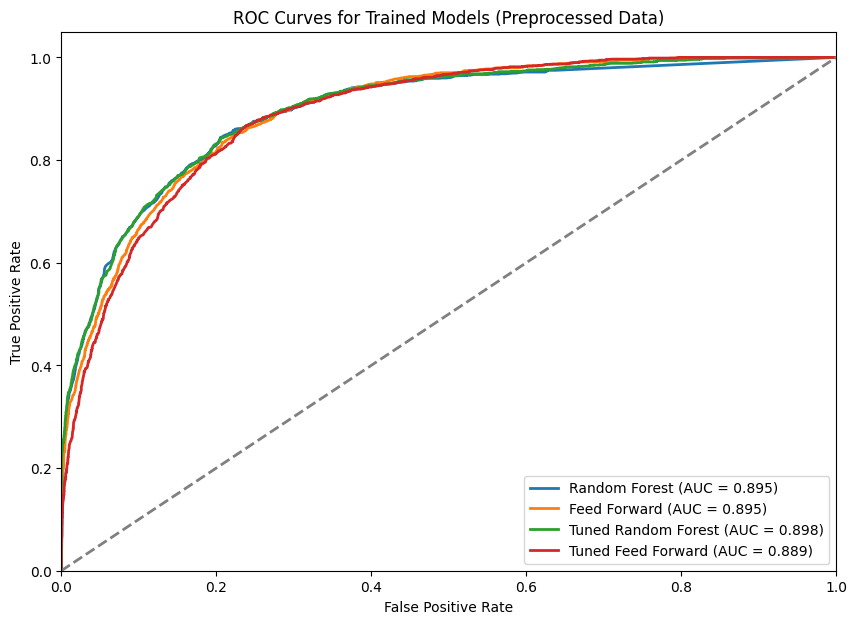

In [32]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 7))

for name, y_proba in y_probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

# Baseline (random classifier)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Trained Models (Preprocessed Data)")
plt.legend(loc="lower right")
plt.show()

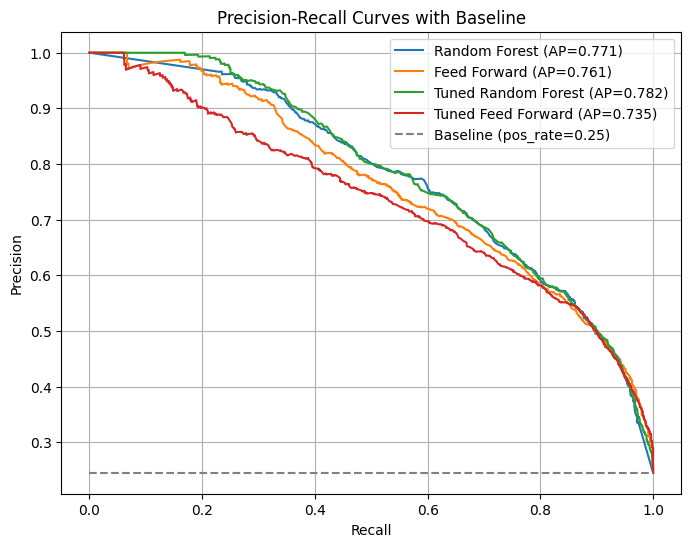

In [34]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Proportion of positive class in test set
pos_rate = np.mean(y_test)

plt.figure(figsize=(8,6))
for name, y_scores in y_probas.items():
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

# Add baseline
plt.hlines(pos_rate, 0, 1, colors="gray", linestyles="--", label=f"Baseline (pos_rate={pos_rate:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves with Baseline")
plt.legend()
plt.grid(True)
plt.show()